In [8]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import numpy as np
from scipy.interpolate import make_interp_spline
from sklearn.model_selection import train_test_split
from gpytorch.kernels import Kernel
import pickle
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
X_df=None
X_domain_info=None
y_df=None
with open('X_df.pkl', 'rb') as f:
    X_df = pickle.load(f)
with open('X_domain_info.pkl', 'rb') as f:
    X_domain_info = pickle.load(f)
with open('y_df.pkl', 'rb') as f:
    y_df = pickle.load(f)



num_conc=y_df.shape[1]
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.1, random_state=42)

X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train)
X_test_tensor = torch.tensor(X_test)
y_test_tensor = torch.tensor(y_test)

In [10]:

mask_bool_met = X_df.columns.str.contains("met")
mask_bool_mut = X_df.columns.str.contains("mut")
mask_bool_cna = X_df.columns.str.contains("cna")
mask_bool_dc  = X_df.columns.str.contains("dc")

mask_float_met = np.array(mask_bool_met, dtype=np.float32) 
mask_float_mut = np.array(mask_bool_mut, dtype=np.float32)
mask_float_cna = np.array(mask_bool_cna, dtype=np.float32)
mask_float_dc  = np.array(mask_bool_dc, dtype=np.float32)

diag_matrix_met = torch.tensor(np.diag(mask_float_met))
diag_matrix_mut = torch.tensor(np.diag(mask_float_mut))
diag_matrix_cna = torch.tensor(np.diag(mask_float_cna))
diag_matrix_dc  = torch.tensor(np.diag(mask_float_dc))
filters=(diag_matrix_mut,diag_matrix_met,diag_matrix_cna,diag_matrix_dc)

In [11]:
class HomemadeRBF(Kernel):\
#TODO embed the domain information
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # Define a hyperparameter called 'scale'
        self.homemade_lengthscale = torch.nn.Parameter(torch.tensor(1.0))
        
        # Register the hyperparameter
        self.register_parameter(name='homemade_lengthscale', parameter=self.homemade_lengthscale)
    def forward(self, x1, x2,**params):
        # 扩展维度以便广播
        x1_expanded = x1.unsqueeze(1)  # (8, 1, 28)
        x2_expanded = x2.unsqueeze(0)  # (1, 80, 28)

        variance_matrix = torch.var(x1_expanded - x2_expanded, dim=2)

        return torch.exp(-variance_matrix/(2*(self.homemade_lengthscale**2)))
            

In [20]:
class QuadripleDRPKernel(Kernel):
    def __init__(self,filters, **kwargs):
        super().__init__(**kwargs)
        # Use a base kernel, e.g., RBFKernel
        # self.kernel_mu = HomemadeRBF()
        # self.kernel_met = HomemadeRBF()
        # self.kernel_cn = HomemadeRBF()
        # self.kernel_dc = HomemadeRBF()
        self.kernel_mu =gpytorch.kernels.ScaleKernel( gpytorch.kernels.RBFKernel(batch_shape=torch.Size([10])),batch_shape=torch.Size([10]))
        self.kernel_met =gpytorch.kernels.ScaleKernel( gpytorch.kernels.RBFKernel(batch_shape=torch.Size([10])),batch_shape=torch.Size([10]))
        self.kernel_cn =gpytorch.kernels.ScaleKernel( gpytorch.kernels.RBFKernel(batch_shape=torch.Size([10])),batch_shape=torch.Size([10]))
        self.kernel_dc =gpytorch.kernels.ScaleKernel( gpytorch.kernels.RBFKernel(batch_shape=torch.Size([10])),batch_shape=torch.Size([10]))
        self.filter_mu,self.filter_met,self.filter_cn,self.filter_dc=filters
    
    def forward(self, x1, x2, diag=False, last_dim_is_batch=False, **params):
        # Apply the base kernel
        filter_mu=self.filter_mu
        filter_met=self.filter_met
        filter_cn=self.filter_cn
        filter_dc=self.filter_dc
        
        x1_mu   =   x1 @ filter_mu
        x1_met  =   x1 @ filter_met
        x1_cn   =   x1 @ filter_cn
        x1_dc   =   x1 @ filter_dc

        x2_mu   =   x2 @ filter_mu
        x2_met  =   x2 @ filter_met
        x2_cn   =   x2 @ filter_cn
        x2_dc   =   x2 @ filter_dc

        return self.kernel_mu(x1_mu,x2_mu)*self.kernel_met(x1_met,x2_met)*self.kernel_cn(x1_cn,x2_cn)* 1 #self.kernel_dc(x1_dc,x2_dc)

In [21]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    #TODO add input for domain information
    def __init__(self, train_x, train_y,filters, likelihood,):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=num_conc
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            QuadripleDRPKernel(filters), num_tasks=num_conc, rank=2
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)




In [22]:
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_conc)
model = MultitaskGPModel(X_train_tensor, y_train_tensor,filters, likelihood)


# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 175


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = -mll(output, y_train_tensor)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

TypeError: Value after * must be an iterable, not int

In [15]:
def smooth_curve(x, y, num_points=300):
    # 创建平滑的曲线
    x_smooth = np.linspace(x.min(), x.max(), num_points)
    y_smooth = make_interp_spline(x, y)(x_smooth)
    return x_smooth, y_smooth

# Set into eval mode
model.eval()
likelihood.eval()


# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = likelihood(model(X_test_tensor))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()



Num 15 Chosen for display
[1.0264873504638672, 1.0449347496032715, 1.1961958408355713, 1.359668493270874, 1.4161677360534668, 1.2557536363601685, 0.8390876054763794, 0.45263612270355225, 0.05573703721165657, 0.04412376135587692]
[0.9633696675300598, 0.9391133189201355, 0.6642736196517944, 0.3273734450340271, -0.03387957811355591, -0.333346962928772, -0.37215960025787354, -0.27124327421188354, -0.021079760044813156, -0.026958385482430458]


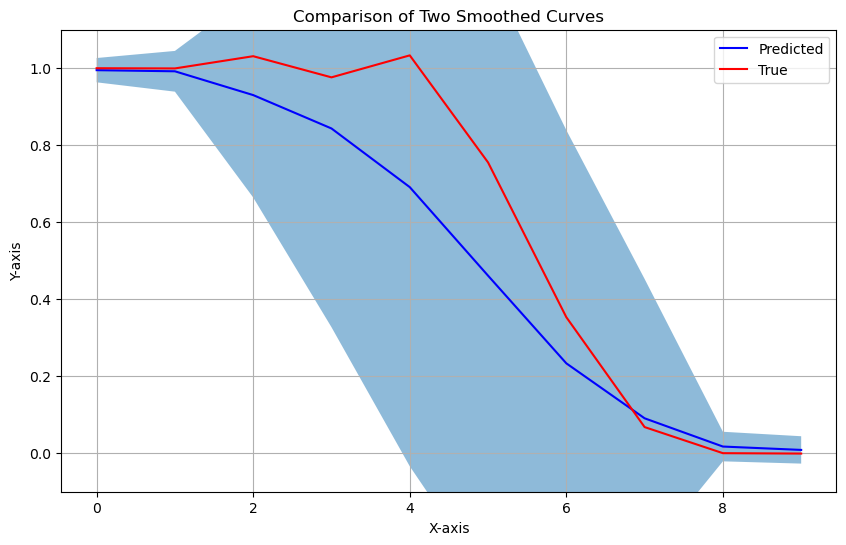

In [19]:

x_plt_axis = np.arange(len(mean[0]))

random_num = np.random.randint(0, len(mean), size=1)[0]
y_pred=mean[random_num]
y_true=y_test_tensor[random_num]
print("Num "+str(random_num)+" Chosen for display")
x_plt_axis = np.linspace(0, len(y_pred) - 1, len(y_pred))
# 创建图形、
selected_upper_bound=lower[random_num].numpy().tolist()
selected_lower_bound=upper[random_num].numpy().tolist()

print(selected_lower_bound)
print(selected_upper_bound)
plt.figure(figsize=(10, 6))
plt.plot(x_plt_axis, y_pred, label='Predicted', color='blue')
plt.plot(x_plt_axis, y_true, label='True', color='red')
plt.fill_between(x_plt_axis, selected_lower_bound, selected_upper_bound, alpha=0.5)
plt.ylim(-0.1, 1.1)
# 添加标题和标签
plt.title('Comparison of Two Smoothed Curves')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.grid(True)
